# Herron Topic 3 - Practice - Sec 02

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. Projects:
    1. Project 1:
        1. I am still grading
        2. I plan to finish grading by Friday
    2. Project 2:
        1. Due on Friday, 3/28, at 11:59 PM
        2. We will use class time next week for group work
        3. Ask your questions here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2738173>
2. Assessments:
    1. ***Both assessments are in class on Tuesday, 4/15***
    2. Programming assessment: Should take 15 minutes and will be based on the questions here:
    3. MSFQ assessment (only for MSFQ students): Should take 45 minutes and based on the 5 required MSFQ courses (standby for a Canvas announcement with more details after I discuss it with the MSFQ program director)

## Five-Minute Review

Quantitative value investing is a systematic investment strategy that combines the principles of value investing with data-driven, quantitative techniques.
It involves identifying undervalued securities---those trading below their intrinsic value---using predefined, measurable criteria rather than subjective judgment.
Common criteria are price/earnings (P/E) and price/book (P/B) ratios.
Here, we will use the book-to-market equity ratio (B/M), which is common in the academic literature and quantitative investing.

The key concepts in this topic are creating metrics, forming portfolios, and backtesting the strategy.

##  Practice

### Re-implement the value strategy from the lecture notebook

#### Read the data

This code reads stock market data from a file called `crsp.csv` and prepares it for analysis.
It loads the data into a data frame, makes sure the dates are in the right format, and marks certain letters (`A`, `B`, and `C`) as missing values.
Then, it filters the data to include only records from 1965 or later, sorts it by company and date, and adds two new columns: one for market equity (calculated as the number of shares times the stock price, converted to millions), and another to adjust all dates to the end of each month.

In [3]:
crsp = (
    pd.read_csv(
        filepath_or_buffer='crsp.csv',  # Read data from crsp.csv file
        parse_dates=['date'],           # Convert 'date' column to datetime format
        na_values=['A', 'B', 'C']       # Treat 'A', 'B', 'C' as missing values (NaN)
    )
    .query('date >= 1965')              # Filter to keep only data from 1965 onward
    .sort_values(['PERMNO', 'date'])    # Sort by company identifier (PERMNO) and date
    .assign(
        ME=lambda x: x['SHROUT'] * x['PRC'].abs() / 1_000,  # Calculate market equity (ME) as shares outstanding * absolute price / 1000
        date=lambda x: x['date'] + pd.offsets.MonthEnd(0)   # Adjust dates to the last day of each month
    )
)

In [4]:
crsp.head()

,PERMNO,date,SHRCD,PRC,RET,SHROUT,ME
0,10000,1986-01-31,10,-4.3750,NaN,3680.0000,16.1000
1,10000,1986-02-28,10,-3.2500,-0.2571,3680.0000,11.9600
2,10000,1986-03-31,10,-4.4375,0.3654,3680.0000,16.3300
3,10000,1986-04-30,10,-4.0000,-0.0986,3793.0000,15.1720
4,10000,1986-05-31,10,-3.1094,-0.2227,3793.0000,11.7939


This code brings in financial data from a file named `compustat.csv` and prepares it for analysis.
It loads the data into a data frame, formats dates, and filters out any records before 1965.
Then, it sorts the data by company, fiscal year, and date.
Finally, it removes any duplicate entries for the same company and fiscal year, keeping only the most recent record.

In [5]:
compustat = (
    pd.read_csv(
        filepath_or_buffer='compustat.csv',  # Read data from compustat.csv file
        parse_dates=['datadate']              # Convert 'datadate' column to datetime format
    )
    .query('datadate >= 1965')                # Filter to keep only data from 1965 onward
    .sort_values(['LPERMNO', 'fyear', 'datadate'])  # Sort by company identifier (LPERMNO), fiscal year, and date
    .drop_duplicates(subset=['LPERMNO', 'fyear'], keep='last')  # Keep only the latest record per company and fiscal year
)

In [6]:
compustat.head()

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,ceq,ib,costat
165681,13007,10000,1986-10-31,1986.0000,INDL,C,D,STD,USD,0.4180,-0.7300,I
165586,12994,10001,1986-06-30,1986.0000,INDL,C,D,STD,USD,5.4320,0.6690,I
165587,12994,10001,1987-06-30,1987.0000,INDL,C,D,STD,USD,5.3690,0.3120,I
165588,12994,10001,1988-06-30,1988.0000,INDL,C,D,STD,USD,5.5120,0.5420,I
165589,12994,10001,1989-06-30,1989.0000,INDL,C,D,STD,USD,6.3210,1.2080,I


About 64 percent of firm-years have December fiscal-year ends.

In [7]:
compustat['datadate'].dt.month.value_counts() / compustat['datadate'].shape[0]

datadate
12   0.6401
6    0.0723
9    0.0609
3    0.0518
10   0.0341
1    0.0334
8    0.0203
7    0.0187
5    0.0187
4    0.0179
11   0.0173
2    0.0146
Name: count, dtype: float64

#### Create the interim data frames

This code finds the market value of equity (`ME`) as of December each year from the `crsp` data frame (to match with book value of equity `ceq` from the `compustat` data frame below).
It filters out any rows where market equity is zero or negative, then sorts the data by company and date.
Next, it groups the data by company and year, focusing on December values.
Finally, it selects the last market equity value for each company in each year, giving us the December `ME`.

In [8]:
mve = (
    crsp
    .query('ME > 0')                            # Filter for positive market equity values
    .sort_values(['PERMNO', 'date'])            # Sort by company identifier (PERMNO) and date
    .groupby(by=['PERMNO', pd.Grouper(key='date', freq='YE-DEC')])  # Group by company and year-end December
    [['ME']]                                    # Select the market equity (ME) column
    .last()                                     # Take the last ME value for each group (December value)
)

In [9]:
mve.head()

ME
PERMNO date             
10000  1986-12-31 1.9816
       1987-12-31 0.8516
10001  1986-12-31 6.9370
       1987-12-31 5.8280
       1988-12-31 6.3623

This code finds the book value of equity (`ceq`) as of December each year from the `compustat` data frame.
It filters out any rows where common equity is zero or negative, then sorts the data by company and date.
Next, it groups the data by company and year, focusing on December values.
Finally, it selects the last common equity value for each company in each year, giving us the December `ceq`.

In [10]:
bve = (
    compustat
    .query('ceq > 0')                            # Filter for positive common equity values
    .sort_values(['LPERMNO', 'datadate'])        # Sort by company identifier (LPERMNO) and date
    .groupby(by=['LPERMNO', pd.Grouper(key='datadate', freq='YE-DEC')])  # Group by company and year-end December
    [['ceq']]                                    # Select the common equity (ceq) column
    .last()                                      # Take the last CEQ value for each group (December value)
)

In [11]:
bve.head()

ceq
LPERMNO datadate         
10000   1986-12-31 0.4180
10001   1986-12-31 5.4320
        1987-12-31 5.3690
        1988-12-31 5.5120
        1989-12-31 6.3210

#### Combine the data frames and form portfolios

This code shows a simple example of how to form portfolios using the `pd.qcut()` function.
It takes a sequence of numbers from 0 to 9 and splits them into 2 equal groups (quantiles), assigning them to either a low or high category.
The `labels=False` argument gives us numeric group identifiers (0 or 1), and adding 1 shifts these to 1 or 2, which can represent portfolio numbers.

In [12]:
1 + pd.qcut(x=np.arange(10), q=2, labels=False)

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

::: {.callout-note}

In class, in the following cell, I used multiple cursors to simultaneously type two `.rename_axis(index=['PERMNO', 'Date'])` methods.
If you hold down the `CTRL` key, every mouse click will generate a new cursor.
Each cursor will do the same action (e.g., typing, highlighting, and deleting).
More [here](https://discourse.jupyter.org/t/most-useful-keyboard-shortcuts-for-notebook-lab/18113).

:::

This code creates portfolios based on book-to-market (`BM`) ratios using the `bve` and `mve` data frames.
It starts by aligning the company and date indexes of both datasets and merges them, keeping only rows with matching data.
Next, it calculates the `BM` ratio by dividing book value of equity (`ceq`) by market value of equity (`ME`).
After resetting the index, it shifts the dates forward by 7 months to time the portfolio formation correctly, giving 6 months between `BM` calculation and buying stocks at the end of June to receive July returns.
Finally, for each date, it sorts the `BM` ratios into 10 equal groups (deciles) and assigns portfolio numbers from 1 to 10.

In [13]:
portfolios = (
    bve
    .rename_axis(index=['PERMNO', 'Date'])  # Rename index columns for consistency
    .join(
        other=mve.rename_axis(index=['PERMNO', 'Date']),  # Merge with market value data using matching company and date
        how='inner'                               # Keep only rows where both datasets have data
    )
    .assign(BM=lambda x: x['ceq'] / x['ME'])      # Calculate book-to-market ratio (BVE / MVE)
    .reset_index()                                # Convert index back to columns
    .assign(
        Date=lambda x: x['Date'] + pd.offsets.MonthEnd(7),  # Shift date forward 7 months to align with portfolio formation
        Portfolio=lambda x: x.groupby('Date')['BM'].transform(  # Assign portfolios based on BM quantiles
            lambda x: 1 + pd.qcut(x=x, q=10, labels=False)  # Split BM into 10 quantiles (0-9), add 1 to get 1-10
        )
    )
)

This code creates a bar chart showing the average book-to-market (`BM`) ratio for each portfolio using the `portfolios` data frame.
It groups the data by portfolio number (1 to 10), calculates the mean `BM` ratio for each group, and then plots these averages as bars.
As expected, we see that `BM` rises from portfolio 1 to 10.

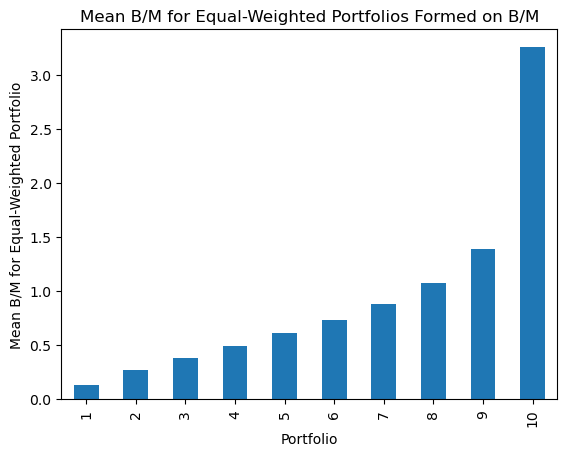

In [14]:
(
    portfolios
    .groupby(by=['Portfolio', 'Date'])  # Group data by portfolio number and date
    ['BM']                              # Select the book-to-market (BM) column
    .mean()                             # Calculate the mean BM for each portfolio-date combination
    .groupby(by='Portfolio')            # Group again by portfolio to average across all dates
    .mean()                             # Calculate the time-averaged mean BM for each portfolio
    .plot(kind='bar')                   # Plot the results as a bar chart
)
plt.ylabel('Mean B/M for Equal-Weighted Portfolio')
plt.title('Mean B/M for Equal-Weighted Portfolios Formed on B/M')
plt.show()

::: {.callout-note}
Start here on Friday!
:::

#### Backtest the strategy

### Re-implement the value strategy from the lecture notebook *with value-weighted portfolios*

### Estimate the $\alpha$s of the equal-weighted and value-weighted portfolios

### Implement a momentum strategy

Form deciles on the 11-month returns from months $t-12$ to month $t-1$.